In [1]:
import numpy as np
import cv2
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import mean_squared_error

In [2]:
ImageCount = pd.read_excel('./data/ImageCount.xlsx')

In [3]:
def getTreeLogCount(filename):
    img = cv2.imread(filename, 0)
    img_clr = cv2.imread(filename, 1)
    blur = cv2.GaussianBlur(img_clr,(9,9),3)
    hsv_img = cv2.cvtColor(blur, cv2.COLOR_BGR2HSV)
    lower_shade = np.array([6,60,160])
    upper_shade = np.array([20,255,255])

    frame_threshed = cv2.inRange(hsv_img, lower_shade, upper_shade)
    element = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2,2))
    mask_iterations = 10
    frame_threshed_mask = frame_threshed
    for i in range(0, mask_iterations):
        frame_threshed_mask = cv2.erode(frame_threshed_mask, element, iterations = 1)
    #for i in range(0, mask_iterations):
        frame_threshed_mask = cv2.dilate(frame_threshed_mask, element, iterations = 1)
    # noise removal
    kernel = np.ones((3,3),np.uint8)
    opening = cv2.morphologyEx(frame_threshed_mask,cv2.MORPH_OPEN,kernel, iterations = 2)
    # sure background area
    sure_bg = cv2.dilate(opening,kernel,iterations=3)
    # Finding sure foreground area
    dist_transform = cv2.distanceTransform(opening,cv2.DIST_L2,5)
    ret, sure_fg = cv2.threshold(dist_transform,0.1*dist_transform.max(),255,0)
    # Finding unknown region
    sure_fg = np.uint8(sure_fg)
    unknown = cv2.subtract(sure_bg,sure_fg)

    # Marker labelling
    ret, markers = cv2.connectedComponents(sure_fg)
    # Add one to all labels so that sure background is not 0, but 1
    markers = markers+1
    # Now, mark the region of unknown with zero
    markers[unknown==255] = 0

    markers = cv2.watershed(img_clr,markers)
    img_clr[markers == -1] = [255,0,0]
    
    from skimage.measure import regionprops, label
    regions = regionprops(markers)
    return (len(regions) - 1)
    #print('Number of tree logs (method 2):', len(regions) - 1)

In [4]:
ImageCount['PredictedCount'] = 0

In [5]:
for i in range(0, 104):
    try:
        count = getTreeLogCount("./data/Img" + str(i+1) + ".jpg")
        #print(count)
        ImageCount.at[i, 'PredictedCount'] = count
    except:
        #print("Error: "+str(i+1))
        ImageCount.at[i, 'PredictedCount'] = 0
        #print(0)
print("Done")

Done


In [32]:
np.sqrt(mean_squared_error(ImageCount.Counts, ImageCount.PredictedCount))

41.49953660538318

In [36]:
def accuracy_measure(predicted, actual):
    raw_abs = abs(predicted - actual)/actual
    if(raw_abs > 1.0):
        raw_abs = 1
    if(raw_abs < 0.0):
        raw_abs = 0
    return (1-raw_abs)
    

In [37]:
ImageCount['AccPercent'] = ImageCount.apply(lambda x: accuracy_measure(x.PredictedCount, x.Counts), axis =1)

In [38]:
ImageCount

,Image Name,Counts,PredictedCount,AccPercent
0,Img1,6,6,1.000000
1,Img2,25,28,0.880000
2,Img3,33,98,0.000000
3,Img4,36,27,0.750000
4,Img5,12,10,0.833333
5,Img6,65,126,0.061538
6,Img7,32,53,0.343750
7,Img8,15,12,0.800000
8,Img9,61,52,0.852459
9,Img10,33,125,0.000000


In [39]:
np.mean(ImageCount.AccPercent)

0.3668303113573345

In [10]:
filename = './data/Img4.jpg'

In [11]:
img = cv2.imread(filename, 0)

In [12]:
img_clr = cv2.imread(filename, 1)

In [13]:
blur = cv2.GaussianBlur(img_clr,(3,3),3)

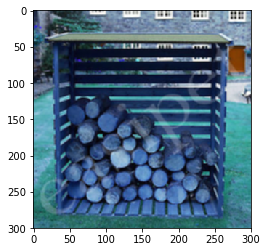

In [14]:
plt.imshow(blur)

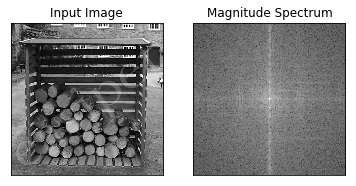

In [15]:
dft = cv2.dft(np.float32(img),flags = cv2.DFT_COMPLEX_OUTPUT)
dft_shift = np.fft.fftshift(dft)

magnitude_spectrum = 20*np.log(cv2.magnitude(dft_shift[:,:,0],dft_shift[:,:,1]))

plt.subplot(121),plt.imshow(img, cmap = 'gray')
plt.title('Input Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(magnitude_spectrum, cmap = 'gray')
plt.title('Magnitude Spectrum'), plt.xticks([]), plt.yticks([])
plt.show()

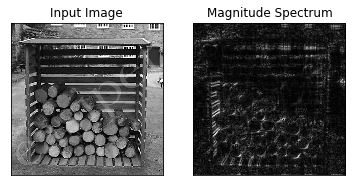

In [16]:
rows, cols = img.shape
crow,ccol = int(rows/2) , int(cols/2)

# create a mask first, center square is 1, remaining all zeros
mask = np.zeros((rows,cols,2),np.uint8)
mask_shift = 280
mask[crow-mask_shift:crow+mask_shift, ccol-mask_shift:ccol+mask_shift] = 1

# apply mask and inverse DFT
fshift = dft_shift*mask
f_ishift = np.fft.ifftshift(fshift)
img_back = cv2.idft(f_ishift)
img_back = cv2.magnitude(img_back[:,:,0],img_back[:,:,1])

plt.subplot(121),plt.imshow(img, cmap = 'gray')
plt.title('Input Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(img_back, cmap = 'gray')
plt.title('Magnitude Spectrum'), plt.xticks([]), plt.yticks([])
plt.show()

In [17]:
new_magnitude_spectrum = magnitude_spectrum
for i in range(0, len(magnitude_spectrum)):
    if i<100 or i>200:
        new_magnitude_spectrum[i] = np.zeros(300)
    else:
        new_magnitude_spectrum[i] = magnitude_spectrum[i] 

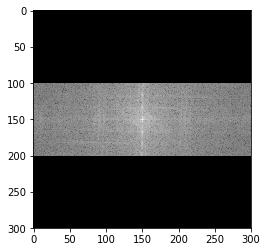

In [18]:
plt.imshow(new_magnitude_spectrum, cmap = 'gray')

In [19]:
hsv_img = cv2.cvtColor(blur, cv2.COLOR_BGR2HSV)

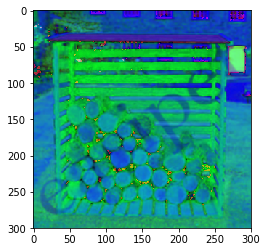

In [20]:
plt.imshow(hsv_img)

In [21]:
h, s, v = cv2.split(hsv_img)

In [22]:
lower_blue = np.array([13,50,120])
upper_blue = np.array([30,255,255])

frame_threshed = cv2.inRange(hsv_img, lower_blue, upper_blue)

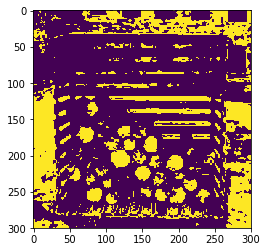

In [23]:
plt.imshow(frame_threshed)

In [24]:
element = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2,2))
mask_iterations = 5
frame_threshed_mask = frame_threshed
for i in range(0, mask_iterations):
    frame_threshed_mask = cv2.erode(frame_threshed_mask, element, iterations = 1)
    frame_threshed_mask = cv2.dilate(frame_threshed_mask, element, iterations = 1)
#frame_threshed_mask = cv2.erode(frame_threshed_mask, element)

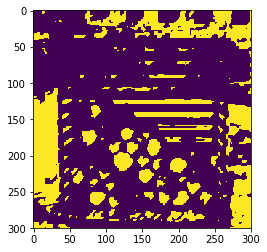

In [25]:
plt.imshow(frame_threshed_mask)

In [26]:
frame_threshed_inv = cv2.bitwise_not(frame_threshed_mask)

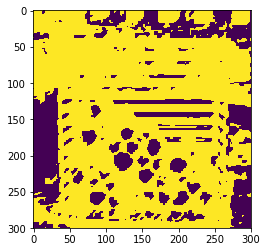

In [27]:
plt.imshow(frame_threshed_inv)

## Watershed

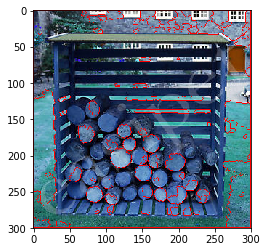

In [28]:
# noise removal
kernel = np.ones((3,3),np.uint8)
opening = cv2.morphologyEx(frame_threshed,cv2.MORPH_OPEN,kernel, iterations = 2)
# sure background area
sure_bg = cv2.dilate(opening,kernel,iterations=3)
# Finding sure foreground area
dist_transform = cv2.distanceTransform(opening,cv2.DIST_L2,5)
ret, sure_fg = cv2.threshold(dist_transform,0.1*dist_transform.max(),255,0)
# Finding unknown region
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg,sure_fg)

# Marker labelling
ret, markers = cv2.connectedComponents(sure_fg)
# Add one to all labels so that sure background is not 0, but 1
markers = markers+1
# Now, mark the region of unknown with zero
markers[unknown==255] = 0

markers = cv2.watershed(img_clr,markers)
img_clr[markers == -1] = [255,0,0]

plt.imshow(img_clr)

In [29]:
np.unique(markers)

array([-1,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 30, 31, 32, 33, 35,
       36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52,
       53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69,
       70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86,
       87, 88, 89, 90, 91, 92, 93, 94, 95], dtype=int32)

In [30]:
from skimage.measure import regionprops, label
regions = regionprops(markers)

print('Number of tree logs (method 2):', len(regions) - 1)

Number of tree logs (method 2): 92


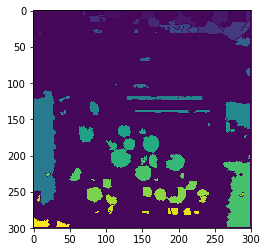

In [31]:
plt.imshow(markers)